# Music Genre Classification - Kaggle Competition

Plan:
* eda
* pre

### Import thư viện

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score


### Load Dataset

In [2]:
df_train = pd.read_csv('data/train (1).csv')
df_test = pd.read_csv('data/test (2).csv')
sample_submission = pd.read_csv('./data/sample_submission (2).csv')

df_train.head()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,37.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,NaN,0.106,0.235,152.429,204947.0,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.0468,0.104,0.380,132.921,191956.0,4,6
2,3,Royal & the Serpent,phuck u,NaN,0.584,0.804,7.0,-6.094,1,0.0619,0.000968,0.6350,0.284,0.635,159.953,161037.0,4,10
3,4,Detroit Blues Band,Missing You,12.0,0.515,0.308,NaN,-14.711,1,0.0312,0.907000,0.0213,0.300,0.501,172.472,298093.0,3,2
4,5,Coast Contra,My Lady,48.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,NaN,0.211,0.619,88.311,254145.0,4,5


### Check data

In [3]:
# Missing
print(df_train.isnull().sum())

# Duplicate
print("Duplicates:", df_train.duplicated().sum())



Id                       0
Artist Name              0
Track Name               0
Popularity             333
danceability             0
energy                   0
key                   1609
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      3541
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64
Duplicates: 0


### Tách numeric và categorical 

In [4]:
# numeric_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()

# print("Numeric columns:", numeric_cols)
# print("Categorical columns:", categorical_cols)


### EDA

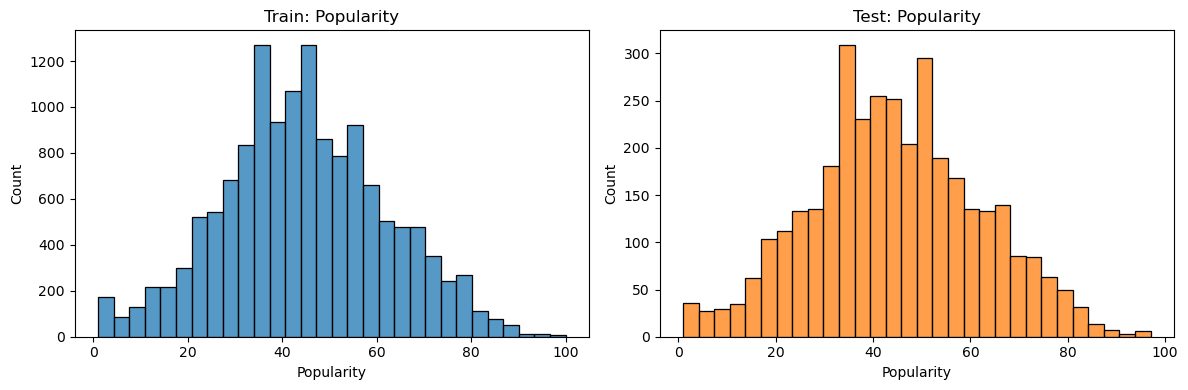

In [5]:
# Histogram (hisplot) of Popularity for train and test
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(df_train['Popularity'].dropna(), bins=30, kde=False, ax=axes[0], color='C0')
axes[0].set_title('Train: Popularity')
axes[0].set_xlabel('Popularity')

sns.histplot(df_test['Popularity'].dropna(), bins=30, kde=False, ax=axes[1], color='C1')
axes[1].set_title('Test: Popularity')
axes[1].set_xlabel('Popularity')

plt.tight_layout()
plt.show()

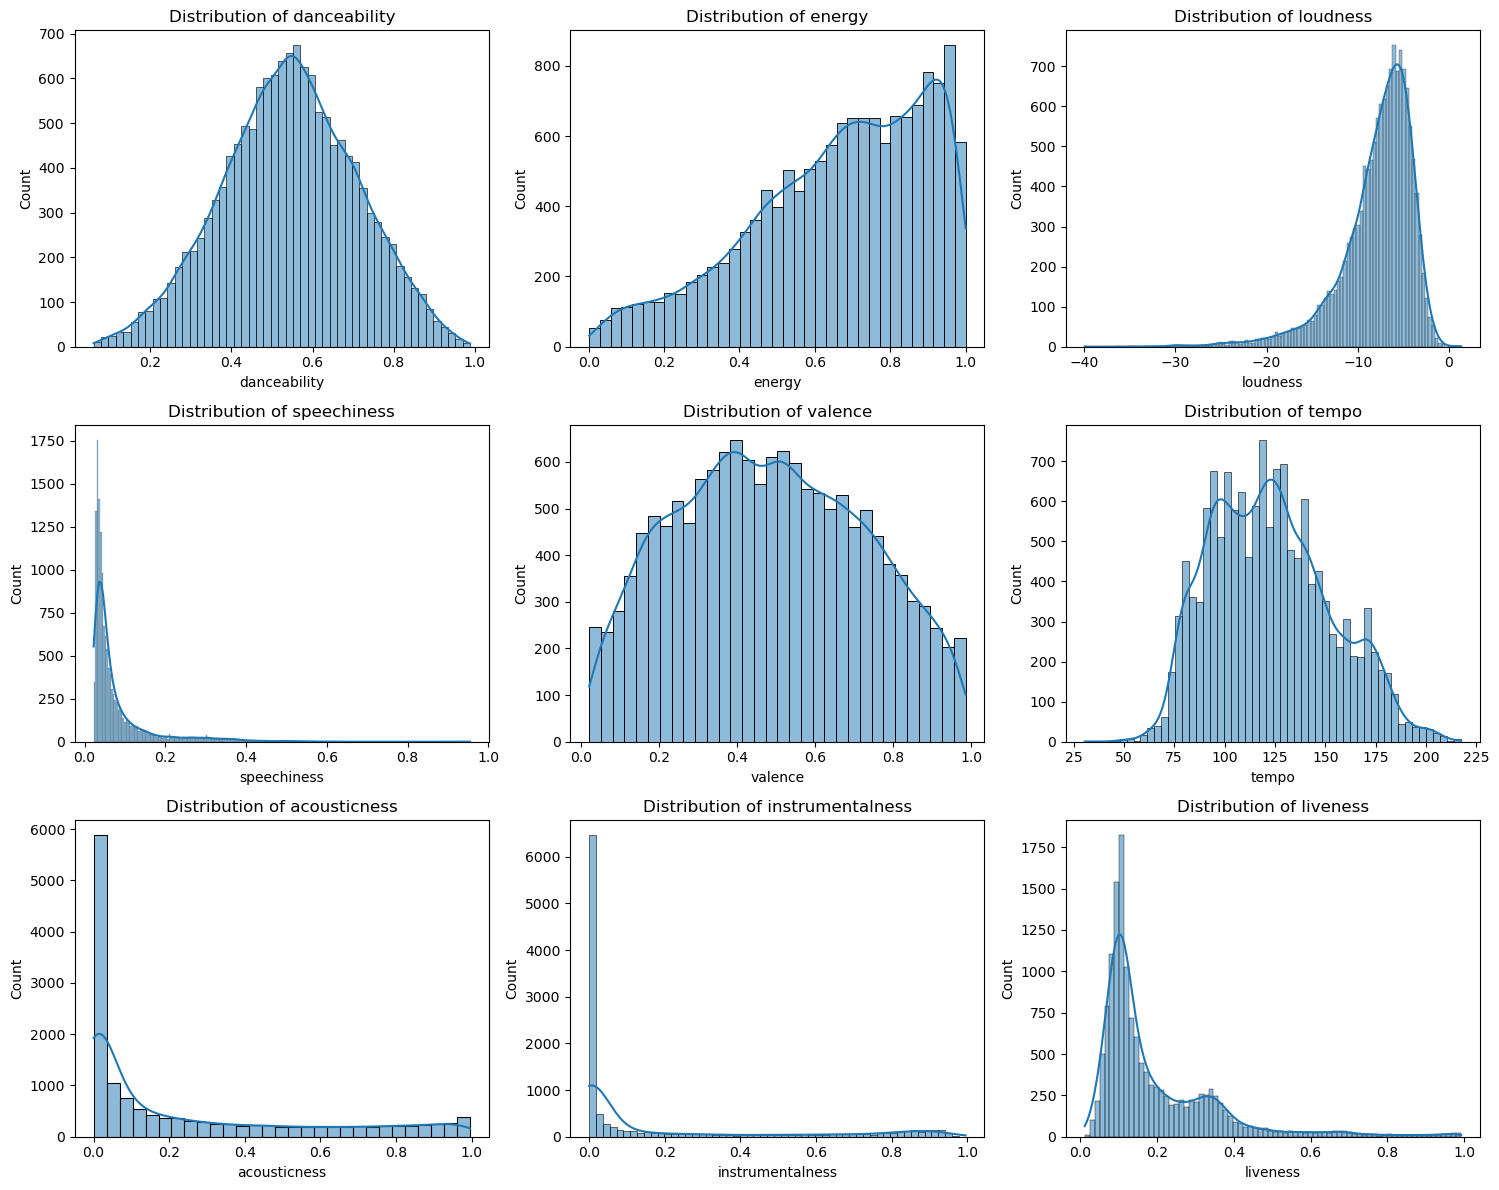

In [6]:
# Distribution of audio features
features = ['danceability', 'energy', 'loudness', 'speechiness', 'valence', 'tempo', 'acousticness', 'instrumentalness', 'liveness']
plt.figure(figsize=(15, 12))
for i, f in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.histplot(df_train[f], kde=True)
    plt.title(f'Distribution of {f}')
plt.tight_layout()
plt.show()


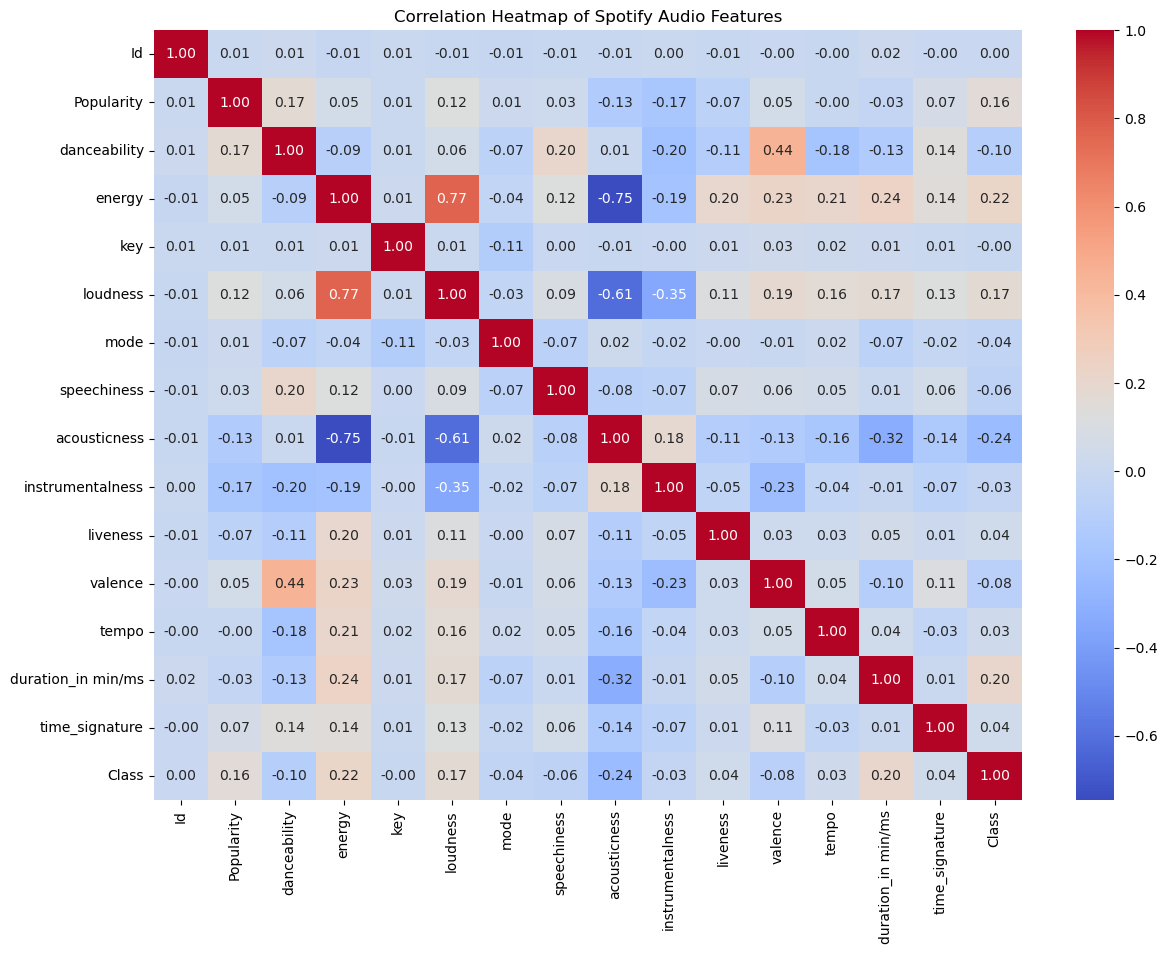

In [7]:
numeric_cols = df_train.select_dtypes(include=['int64', 'float64'])

# Vẽ heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Spotify Audio Features")
plt.show()


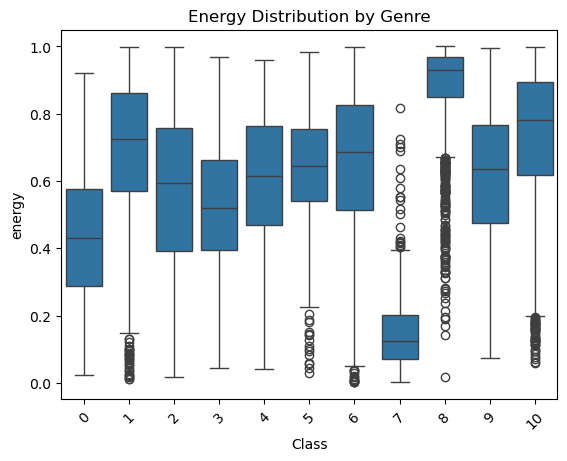

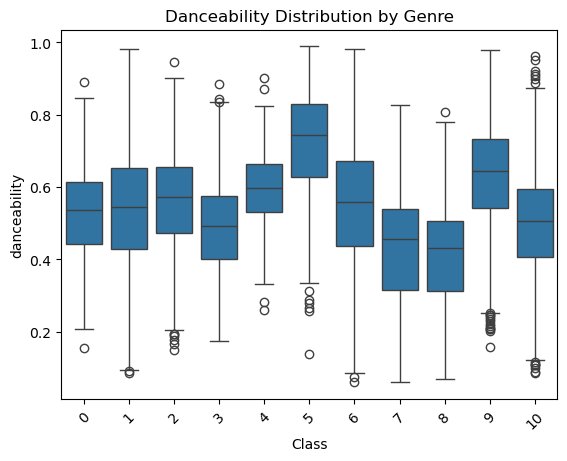

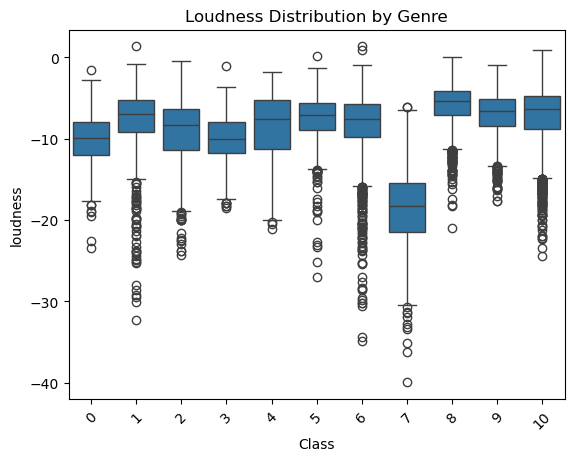

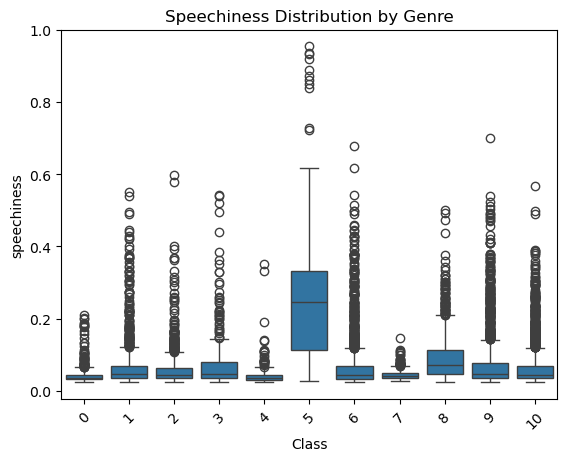

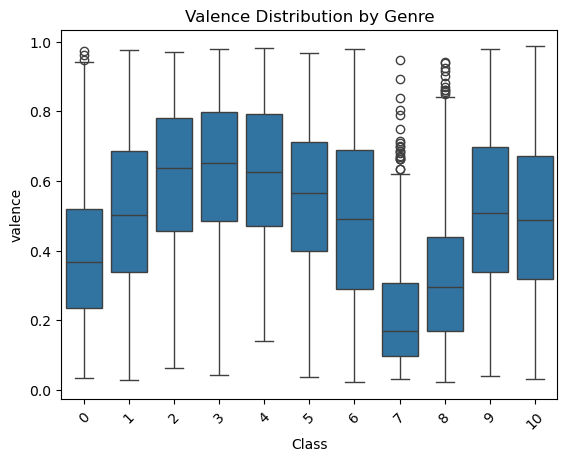

In [8]:
sns.boxplot(data=df_train, x='Class', y='energy')
plt.xticks(rotation=45)
plt.title("Energy Distribution by Genre")
plt.show()

sns.boxplot(data=df_train, x='Class', y='danceability')
plt.xticks(rotation=45)
plt.title("Danceability Distribution by Genre")
plt.show()

sns.boxplot(data=df_train, x='Class', y='loudness')
plt.xticks(rotation=45)
plt.title("Loudness Distribution by Genre")
plt.show()

sns.boxplot(data=df_train, x='Class', y='speechiness')
plt.xticks(rotation=45)
plt.title("Speechiness Distribution by Genre")
plt.show()

sns.boxplot(data=df_train, x='Class', y='valence')
plt.xticks(rotation=45)
plt.title("Valence Distribution by Genre")
plt.show()

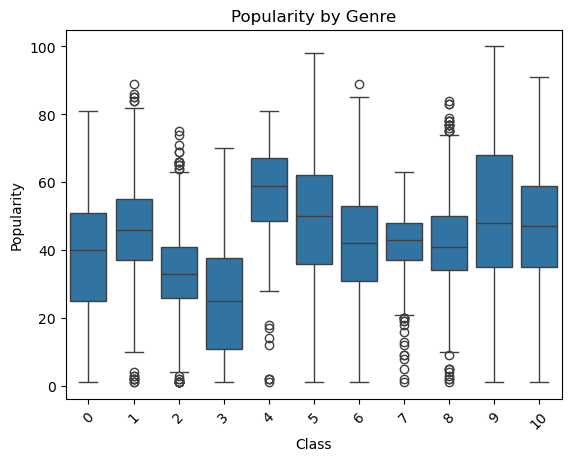

In [9]:
# Column name in df_train is 'Popularity' (capital P)
sns.boxplot(data=df_train, x='Class', y='Popularity')
plt.xticks(rotation=45)
plt.title("Popularity by Genre")
plt.show()


### Data Preprocessing

In [10]:
# 1. Drop cột không cần thiết
df = df_train.drop(['Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')

# 2. Popularity: fill missing bằng median
if df['Popularity'].isnull().sum()>0:
    df['Popularity'].fillna(df['Popularity'].median(), inplace=True)

# 3. Key: fill bằng mode (nếu thiếu)
if df['key'].isnull().sum()>0:
    df['key'].fillna(df['key'].mode()[0], inplace=True)

# 4. Mode: nếu bị string -> map  'Major'/'Minor' -> 1/0
if df['mode'].dtype == 'object':
    df['mode'] = df['mode'].map({'Major':1,'Minor':0})

df['instrumentalness'] = df['instrumentalness'].fillna(0)

print(df.isnull().sum())

Popularity            0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
duration_in min/ms    0
time_signature        0
Class                 0
dtype: int64


C:\Users\MSI VN\AppData\Local\Temp\ipykernel_9688\4183741854.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Popularity'].fillna(df['Popularity'].median(), inplace=True)
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_9688\4183741854.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as

In [11]:
# 1. Drop cột không cần thiết
df_test = df_test.drop(['Id', 'Artist Name', 'Track Name'], axis=1, errors='ignore')

# 2. Popularity: fill missing bằng median
if df_test['Popularity'].isnull().sum() > 0:
    df_test['Popularity'].fillna(df_test['Popularity'].median(), inplace=True)

# 3. Key: fill bằng mode
if df_test['key'].isnull().sum() > 0:
    df_test['key'].fillna(df_test['key'].mode()[0], inplace=True)

# 4. Mode: nếu bị string -> map về 1/0
if df_test['mode'].dtype == 'object':
    df_test['mode'] = df_test['mode'].map({'Major': 1, 'Minor': 0})

# 5. Fix missing instrumentalness
df_test['instrumentalness'] = df_test['instrumentalness'].fillna(0)

# 6. Feature engineering y như train
df_test['loudness_abs'] = df_test['loudness'].abs()

if 'acousticness' in df_test.columns:
    df_test['acousticness_energy_ratio'] = df_test['acousticness'] / (df_test['energy'] + 1e-6)

# 7. Binning popularity
df_test['pop_bin'] = pd.cut(df_test['Popularity'], bins=[-1,20,40,60,80,101], labels=False)

# Kiểm tra null
print(df_test.isnull().sum())


Popularity                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
duration_in min/ms           0
time_signature               0
loudness_abs                 0
acousticness_energy_ratio    0
pop_bin                      0
dtype: int64


C:\Users\MSI VN\AppData\Local\Temp\ipykernel_9688\2198067747.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test['Popularity'].fillna(df_test['Popularity'].median(), inplace=True)
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_9688\2198067747.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always 

### Features Engineering

In [12]:
# Ví dụ: tạo feature loudness_abs = abs(loudness) (nếu muốn)
df['loudness_abs'] = df['loudness'].abs()

# Tạo feature 'acousticness_vs_energy' nếu có acousticness
if 'acousticness' in df.columns:
    df['acousticness_energy_ratio'] = df['acousticness'] / (df['energy'] + 1e-6)

# Binning popularity thành categories (tùy case)
df['pop_bin'] = pd.cut(df['Popularity'], bins=[-1,20,40,60,80,101], labels=False)


### Chuẩn bị hóa dữ liệu

In [13]:
X = df.drop(columns=['Class'])
y = df['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(df_test) 


### Tách train và test 

In [14]:
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

### Train model

In [15]:
cat = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.05,
    depth=8,
    loss_function='MultiClass',
    verbose=0
)

cat.fit(X_train, y_train)
pred_cat = cat.predict(X_val)

print("=== CatBoost Validation Accuracy ===")
print(accuracy_score(y_val, pred_cat))
print(classification_report(y_val, pred_cat))

# ============================
# 3. XGBOOST MODEL
# ============================

model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=9,
    eval_metric='mlogloss'
)

model.fit(X_train, y_train)
y_pred = model.predict(X_val)

print("=== XGBoost Validation Report ===")
print(classification_report(y_val, y_pred))


# ============================
# 4. TRAIN FULL + PREDICT TEST
# ============================

# Chọn model tốt hơn, ví dụ CatBoost:
cat.fit(X, y)  # train full
test_pred = cat.predict(df_test)

# Hoặc nếu XGB tốt hơn thì thay cat bằng model
# model.fit(X, y)
# test_pred = model.predict(df_test)

# ============================
# 5. Xuất submission
# ============================
submit = sample_submission.copy()
submit['Class'] = test_pred.astype(int)
submit.to_csv("submission.csv", index=False)

submit.head()

=== CatBoost Validation Accuracy ===
0.5135416666666667
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       100
           1       0.05      0.02      0.03       220
           2       0.55      0.49      0.52       204
           3       0.81      0.81      0.81        64
           4       0.64      0.66      0.65        62
           5       0.71      0.71      0.71       231
           6       0.32      0.27      0.29       414
           7       0.95      0.93      0.94        92
           8       0.59      0.52      0.55       297
           9       0.54      0.54      0.54       404
          10       0.46      0.60      0.52       792

    accuracy                           0.51      2880
   macro avg       0.57      0.57      0.57      2880
weighted avg       0.49      0.51      0.50      2880

=== XGBoost Validation Report ===
              precision    recall  f1-score   support

           0       0.69      0.79      0.7

,Id,Class
0,14397,6
1,14398,6
2,14399,9
3,14400,10
4,14401,5


In [16]:
# CatBoost
cat = CatBoostClassifier(
    iterations=1200,
    learning_rate=0.05,
    depth=8,
    loss_function='MultiClass',
    verbose=0
)
cat.fit(X, y)
pred_cat_prob = cat.predict_proba(df_test)  # xác suất

# XGBoost
model = XGBClassifier(
    n_estimators=500,
    max_depth=8,
    learning_rate=0.03,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softprob',  # note softprob
    num_class=9,
    eval_metric='mlogloss'
)
model.fit(X, y)
pred_xgb_prob = model.predict_proba(df_test)

ensemble_prob = 0.5 * pred_cat_prob + 0.5 * pred_xgb_prob

# Chọn class có xác suất cao nhất
import numpy as np
test_pred_ensemble = np.argmax(ensemble_prob, axis=1) + 1  # +1 vì class từ 1-9

submit = sample_submission.copy()
submit['Class'] = test_pred_ensemble.astype(int)
submit.to_csv('submission_ensemble.csv', index=False)
submit.head()


KeyboardInterrupt: 